Functional Strategy Profiles

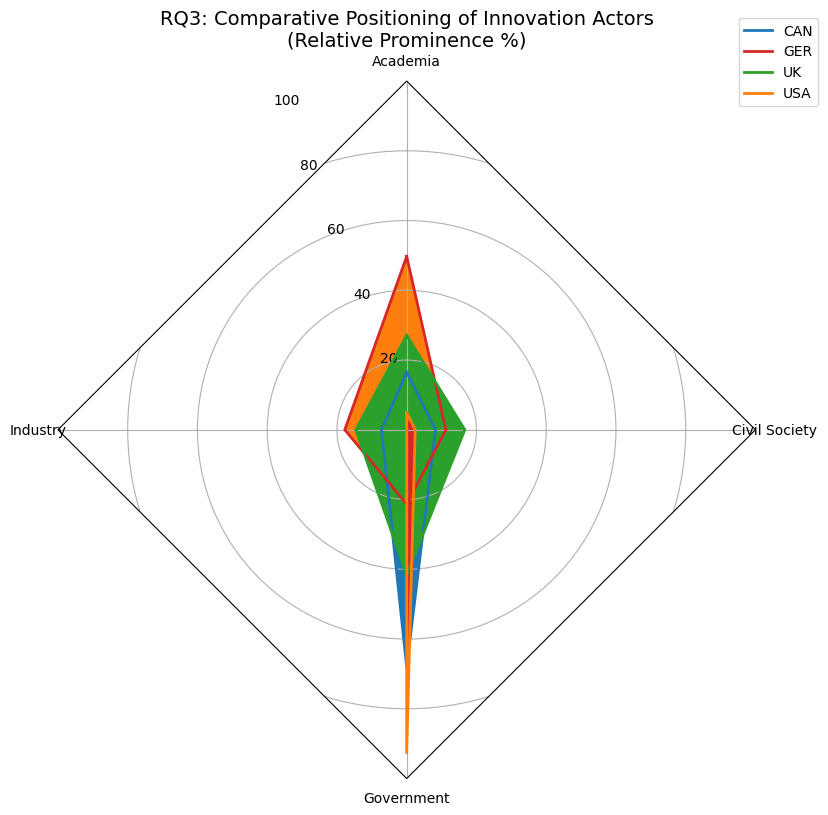

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# 1. Load Data
df = pd.read_csv('entities_to_edit.csv') # Ensure this file is in the working directory

# 2. Filter & Process
relevant_actors = ['Academia', 'Industry', 'Government', 'Civil Society']
df_filtered = df[df['qh_category'].isin(relevant_actors)]

# Count frequencies
counts = df_filtered.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')
pivot_df = counts.pivot(index='qh_category', columns='Country', values='Frequency').fillna(0)

# Normalize to Percentages
pivot_pct = pivot_df.div(pivot_df.sum(axis=0), axis=1) * 100

# 3. Radar Chart Setup
def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    class RadarAxes(PolarAxes):
        name = 'radar'
        RESOLUTION = 1
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')
        def fill(self, *args, **closed):
            return super().fill(closed=True, *args)
        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)
        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)
        def _gen_axes_patch(self):
            return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
        def _gen_axes_spines(self):
            spine = Spine(axes=self, spine_type='circle', path=Path.unit_regular_polygon(num_vars))
            spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta

# 4. Plotting
categories = ['Academia', 'Industry', 'Government', 'Civil Society']
countries = ['CAN', 'GER', 'UK', 'USA']
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e'] # Blue, Red, Green, Orange

N = len(categories)
theta = radar_factory(N, frame='polygon')

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

for i, country in enumerate(countries):
    # Get values for this country in the correct category order
    values = [pivot_pct.loc[cat, country] if cat in pivot_pct.index else 0 for cat in categories]
    ax.plot(theta, values, color=colors[i], label=country, linewidth=2)
    ax.fill(theta, values, facecolor=colors[i], alpha=0.1)

ax.set_rgrids([20, 40, 60, 80, 100])
ax.set_varlabels(categories)
ax.set_title('RQ3: Comparative Positioning of Innovation Actors\n(Relative Prominence %)', position=(0.5, 1.1), ha='center', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

Functional Role Proportions:
Functional_Role  Ecosystem & Intermediaries  Funding & Support  \
Country                                                          
CAN                                0.082474           0.360825   
GER                                0.112426           0.076923   
UK                                 0.284722           0.062500   
USA                                0.024390           0.170732   

Functional_Role  Governance & Strategy  Industry & Commercialization  \
Country                                                                
CAN                           0.298969                      0.072165   
GER                           0.183432                      0.112426   
UK                            0.201389                      0.104167   
USA                           0.609756                      0.000000   

Functional_Role  R&D Execution  
Country                         
CAN                   0.185567  
GER                   0.514793  
UK       

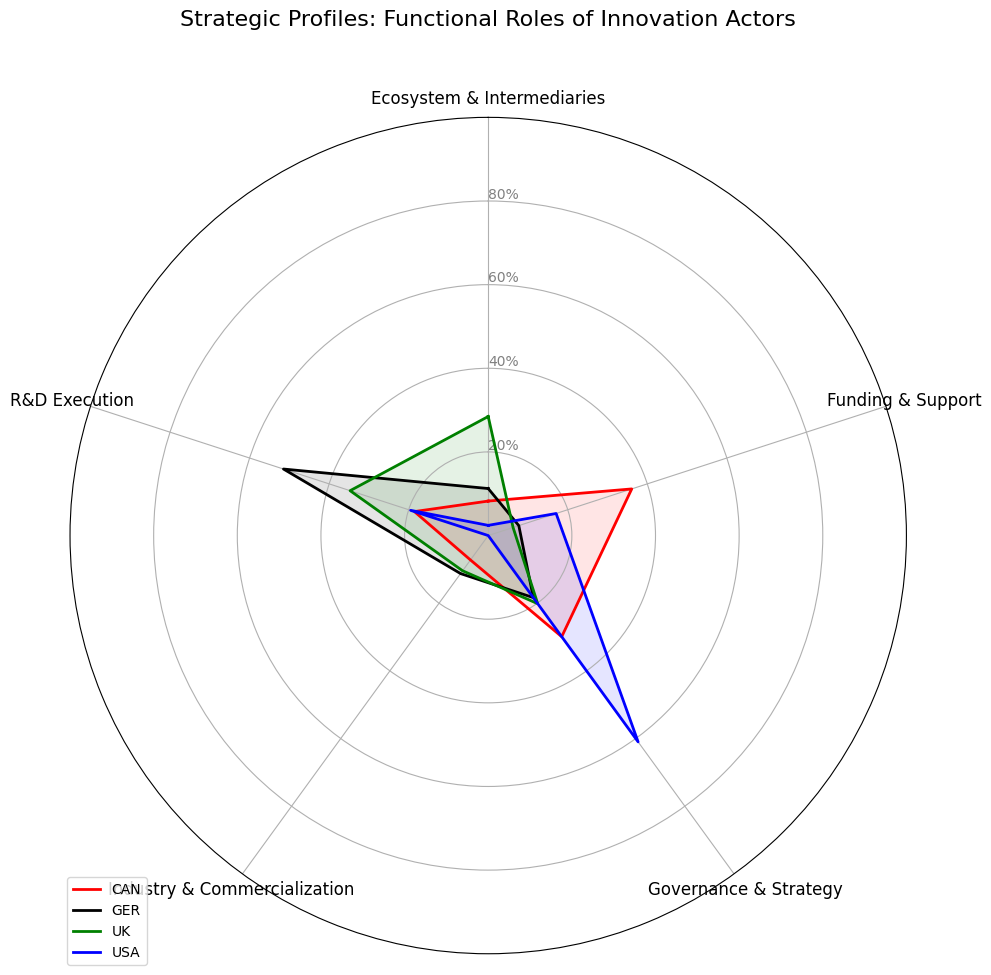

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Load data
entities_df = pd.read_csv('entities_to_edit.csv')

# Define Functional Role Mapping
role_mapping = {
    'Policy Makers': 'Governance & Strategy',
    'Federal Agency': 'Governance & Strategy',
    'Government': 'Governance & Strategy',
    'Public Administration': 'Governance & Strategy',
    'Regulatory Agency': 'Governance & Strategy',
    'National Intelligence Agency': 'Governance & Strategy',
    'Strategic Defense Partnership': 'Governance & Strategy',
    'State-Owned Enterprises (SOEs)': 'Governance & Strategy', # Depending on context, usually execution but often directed

    'Funding Agencies': 'Funding & Support',
    'Government Support Services': 'Funding & Support',
    'Governent Support Service': 'Funding & Support',
    'Venture Capital / Investors': 'Funding & Support',
    'Bank': 'Funding & Support',

    'Public Research Orgs (PROs)': 'R&D Execution',
    'Public Research ORGs (PRO)': 'R&D Execution',
    'Higher Education Institutions (HEIs)': 'R&D Execution',
    'Federal Research Organization': 'R&D Execution',
    'Research Consortium': 'R&D Execution',
    'Academia': 'R&D Execution', # Fallback

    'Private Firms (Corporates)': 'Industry & Commercialization',
    'Start-ups': 'Industry & Commercialization',
    'Industry': 'Industry & Commercialization', # Fallback
    'Consulting': 'Industry & Commercialization',
    'Education & Skills Provider': 'Industry & Commercialization', # Arguable, but market facing

    'Intermediaries': 'Ecosystem & Intermediaries',
    'Civil Society': 'Ecosystem & Intermediaries', # Fallback
    'Intergovernmental Organization': 'Ecosystem & Intermediaries',
    'Think Tank': 'Ecosystem & Intermediaries',
    'Foundation': 'Ecosystem & Intermediaries',
    'Network': 'Ecosystem & Intermediaries'
}

# Apply mapping
def get_role(row):
    sub = row['qh_sub_category']
    cat = row['qh_category']
    
    if sub in role_mapping:
        return role_mapping[sub]
    # Fallback logic if sub-category is not precise or 'not specified'
    if cat == 'Government':
        return 'Governance & Strategy' # Default for generic gov
    if cat == 'Academia':
        return 'R&D Execution'
    if cat == 'Industry':
        return 'Industry & Commercialization'
    if cat == 'Civil Society':
        return 'Ecosystem & Intermediaries'
    return 'Other'

entities_df['Functional_Role'] = entities_df.apply(get_role, axis=1)

# Filter out 'Other' and 'not an actor'
functional_df = entities_df[~entities_df['Functional_Role'].isin(['Other', 'not an actor'])].copy()

# Calculate proportions by Country
role_counts = functional_df.groupby(['Country', 'Functional_Role']).size().unstack(fill_value=0)
role_props = role_counts.div(role_counts.sum(axis=1), axis=0)

# Prepare data for Radar Chart
categories = list(role_props.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] # Close the loop

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Colors for countries
colors = {'USA': 'blue', 'CAN': 'red', 'GER': 'black', 'UK': 'green'}

for country in role_props.index:
    values = role_props.loc[country].values.flatten().tolist()
    values += values[:1] # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=country, color=colors.get(country, 'gray'))
    ax.fill(angles, values, color=colors.get(country, 'gray'), alpha=0.1)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories, size=12)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", size=10)
plt.ylim(0, 1.0) # USA hits 0.9 something, so 1.0 is safe

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Strategic Profiles: Functional Roles of Innovation Actors', size=16, y=1.1)

plt.tight_layout()
plt.savefig('strategic_profiles_radar.png')

# Also print the table for the text response
print("Functional Role Proportions:")
print(role_props)

Co-Occurence Probabilities

Silo Scores (Proportion of paragraphs with only 1 actor type):
         Silo Score  Integrated Score
Country                              
USA        0.900000          0.100000
CAN        0.742857          0.257143
GER        0.678571          0.321429
UK         0.700000          0.300000


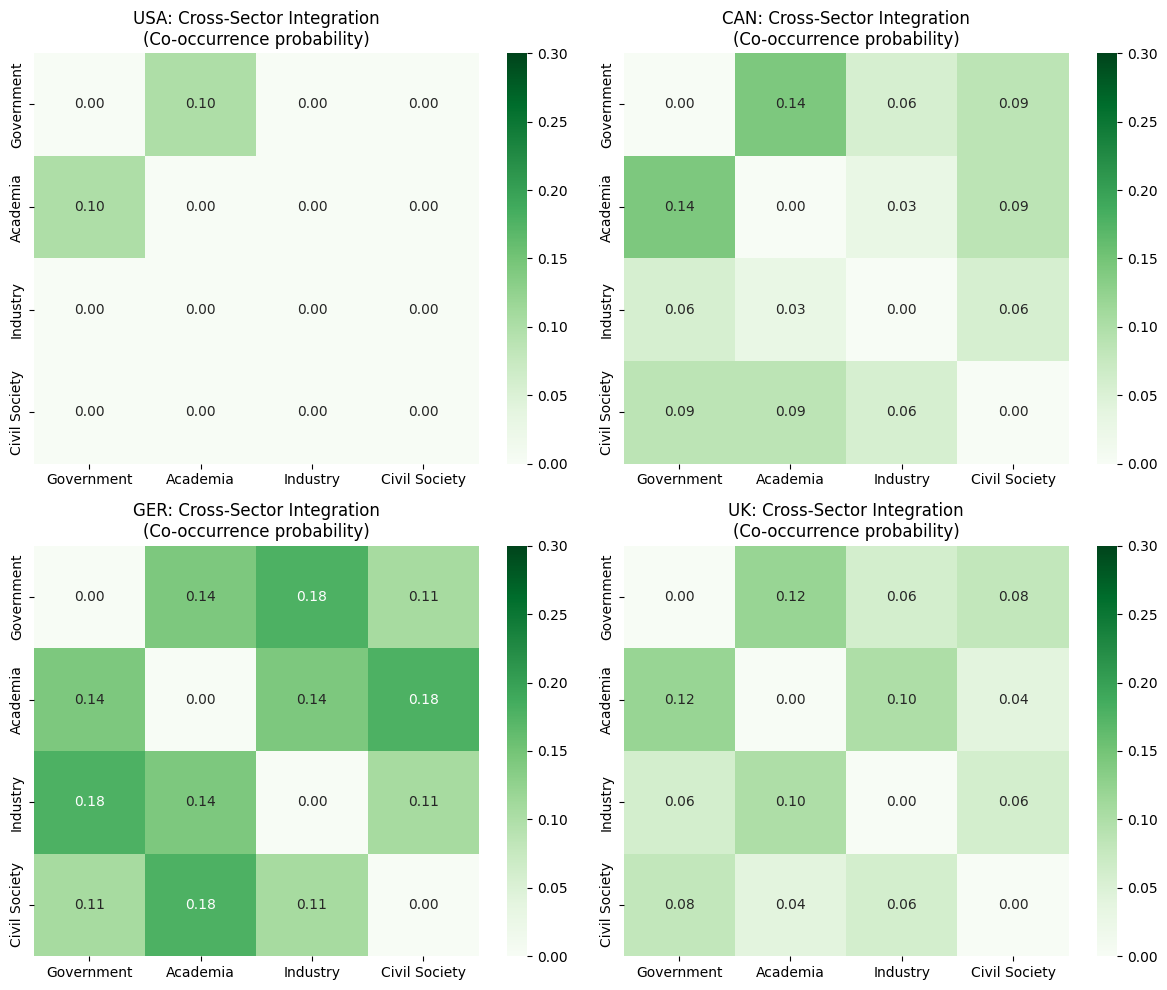

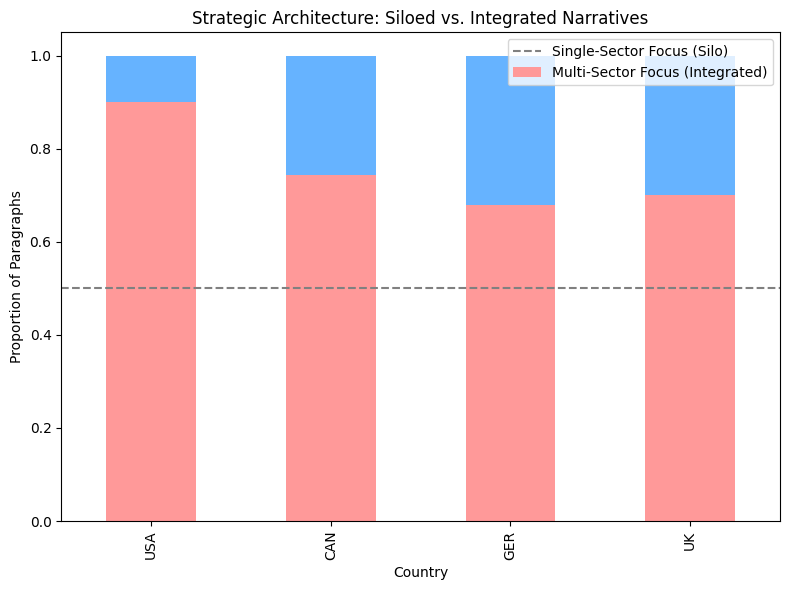

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Load data
entities_df = pd.read_csv('entities_to_edit.csv')

# Define categories of interest
categories = ['Government', 'Academia', 'Industry', 'Civil Society']

# Filter data
df = entities_df[entities_df['qh_category'].isin(categories)].copy()

# Function to calculate co-occurrence matrix per country
def get_cooccurrence(country_df):
    # Group by paragraph to see which actors appear together
    paragraphs = country_df.groupby('Paragraph_ID')['qh_category'].unique()
    
    # Initialize matrix
    matrix = pd.DataFrame(0, index=categories, columns=categories)
    
    # Count pairs
    for cats in paragraphs:
        # Sort to ensure unique pairs (A, B) and (B, A) are handled
        unique_cats = sorted(list(set(cats)))
        if len(unique_cats) > 1:
            for c1, c2 in combinations(unique_cats, 2):
                matrix.loc[c1, c2] += 1
                matrix.loc[c2, c1] += 1 # Symmetric
    
    # Normalize by total paragraphs to make countries comparable
    # (Frequency of co-occurrence per paragraph unit)
    return matrix / len(paragraphs)

# Calculate and Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

country_order = ['USA', 'CAN', 'GER', 'UK']
results = {}

for i, country in enumerate(country_order):
    country_data = df[df['Country'] == country]
    if country_data.empty:
        continue
        
    matrix = get_cooccurrence(country_data)
    results[country] = matrix
    
    # Plot heatmap
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Greens", ax=axes[i], vmin=0, vmax=0.3)
    axes[i].set_title(f'{country}: Cross-Sector Integration\n(Co-occurrence probability)', fontsize=12)

plt.tight_layout()
plt.savefig('cross_sector_integration.png')

# --- SILO ANALYSIS ---
# What % of paragraphs mention ONLY one type of actor?
silo_data = []
for country in country_order:
    country_data = df[df['Country'] == country]
    paragraphs = country_data.groupby('Paragraph_ID')['qh_category'].nunique()
    
    num_siloed = (paragraphs == 1).sum()
    num_integrated = (paragraphs > 1).sum()
    total = len(paragraphs)
    
    silo_score = num_siloed / total if total > 0 else 0
    silo_data.append({'Country': country, 'Silo Score': silo_score, 'Integrated Score': 1-silo_score})

silo_df = pd.DataFrame(silo_data).set_index('Country')
print("Silo Scores (Proportion of paragraphs with only 1 actor type):")
print(silo_df)

# Plot Silo vs Integrated
silo_df.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], figsize=(8, 6))
plt.title('Strategic Architecture: Siloed vs. Integrated Narratives')
plt.ylabel('Proportion of Paragraphs')
plt.axhline(0.5, color='gray', linestyle='--')
plt.legend(['Single-Sector Focus (Silo)', 'Multi-Sector Focus (Integrated)'])
plt.tight_layout()
plt.savefig('silo_vs_integrated.png')